In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("e_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("e_data/data'+number+'.csv")'
        exec(new_string)
        df = 'df'+number
        new_df = locals()[df]
        df_list.append(new_df)
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(item)
    return flat_list
            
band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05])
    return my_fit[1]

In [2]:
spec_list = []
for number in new_array:
    my_string = 'spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

time_list_i = []
for number in new_array:
    my_string = 'ettime'+number+' = df'+number+"['ettime']"
    exec(my_string)
    time = 'ettime'+number
    time_list_i.append(locals()[time])

time_list_f = []
for df in time_list_i:
    for time in df:
        time_list_f.append(time)

total_spectrum = []
for spec in spec_list:
    for spectrum in spec:
        total_spectrum.append(spectrum)

total_spectrum = np.asarray(total_spectrum)
total_spectrum_2 = dc(total_spectrum)
print('List 1: '+str(np.shape(total_spectrum)))
print('List 2: '+str(np.shape(total_spectrum_2))) # Confirms that DeepCopy works correctly

List 1: (12655, 256)
List 2: (12655, 256)


In [ ]:
%matplotlib inline
plt.figure(figsize=(12,8),facecolor='white')
for spectrum in total_spectrum_2[::3]:
    peaks, _ = find_peaks(np.abs(spectrum),height=0.1)
    plt.plot(vims_wave,spectrum)
    plt.plot(vims_wave[peaks],spectrum[peaks],'x',markersize=15)
plt.axhline(y=0.1,linestyle='--')
plt.grid()
plt.show()

### <u>**Use 3-band wide median filtering to attempt to fix issue** (use peaks and NOT np.where() indices this time)</u>

**Steps**
- Identify all the peaks per spectra
- If peak is greater than a certain threshold, make it conform to the median with the rest of the spectra

In [3]:
for (i,j) in zip(range(0,255),range(2,257)): # 3 Channel wide attempt
    median = np.median(total_spectrum[:,i:j])
    vals = total_spectrum_2[:,i:j]
    std = np.std(total_spectrum[:,i:j])
    ind = np.where(np.abs(vals-median)>3*std) # 3 STD as benchmark
    vals[ind] = median

In [ ]:
np.median(total_spectrum[:,254:256])

In [4]:
bad_indices_2 = []
for index,spectrum in enumerate(total_spectrum_2):
    peaks, _ = find_peaks(np.abs(spectrum[158:257]),height=.04)
    peaks = peaks+158
    if len(peaks) > 0:
        bad_indices_2.append(index)
    
bad_spectra_2 = total_spectrum_2[bad_indices_2]
good_spectra_2 = []
for index,spectrum in enumerate(total_spectrum_2):
    if index not in bad_indices_2:
        good_spectra_2.append(spectrum)

bad_spectra_2 = np.asarray(bad_spectra_2)
good_spectra_2 = np.asarray(good_spectra_2)

print(np.shape(bad_spectra_2))
print(np.shape(good_spectra_2))

(2041, 256)
(10614, 256)


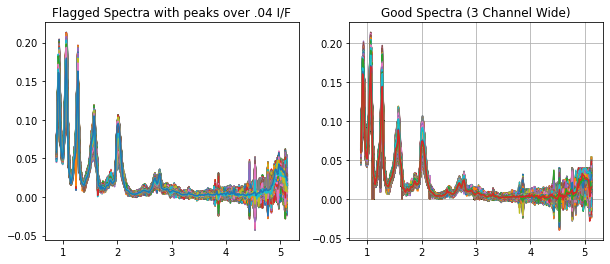

In [6]:
%matplotlib inline
fig,axs = plt.subplots(1,2,figsize=(10,4),facecolor='white')
for spectrum in bad_spectra_2:
    axs[0].plot(vims_wave,spectrum)
    axs[0].set_title('Flagged Spectra with peaks over .04 I/F')
for spectrum in good_spectra_2:
    axs[1].plot(vims_wave,spectrum)
    axs[1].set_title('Good Spectra (3 Channel Wide)')

plt.grid()
plt.show()